### 心理学
> * 动物需要在复杂环境下有效关注值得注意的点
> * 心理学框架：人类根据随意线索和不随意线索选择注意点，即根据是否主观来选择，随意线索不是主观选择，不随意线索是根据主观选择

### 注意力机制
> * 卷积、全连接、池化层都只考虑随意线索
> * 注意力机制则显示的考虑不随意线索
>> * 不随意线索被称之为查询（query）
>> * 每个输入是一个值（value）和随意线索（key）的对
>> * 通过注意力池化层来有偏向性的选择某些输入
> * ![](../images/Attention-Mechanism.png)

### 非参注意力池化层
> * 给定数据$(x_i, y_i), i=1,...,n$
> * 平均池化是最简单的方案：$f(x)=\frac{1}{n}\sum_i y_i$
> * 更好地方案是60年代提出来的Nadaraya-Watson核回归：$f(x)=\sum_{i=1}^{n}\frac{K(x-x_i)}{\sum_{j=1}^{n}K(x-x_j)}y_i$，其中$x$是query，$x_j$是key，$y_i$是value，$K$代表核函数，用来衡量$x$和$x_i$之间的距离。

### Nadaraya-Watson核回归
> * 使用高斯核$K(u)=\frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{2})$
> * 那么$f(x)=\sum_{i=1}^{n}\frac{exp(-\frac{1}{2}(x-x_i)^2)}{\sum_{j=1}^{n}exp(-\frac{1}{2}(x-x_j)^2)}y_i=\sum_{i=1}^{n}softmax(-\frac{1}{2}(x-x_i)^2))y_i$

### 参数化的注意力机制
> 在之前基础上引入可以学习的$w$:$f(x)=\sum_{i=1}^{n}softmax(-\frac{1}{2}((x-x_i)w)^2))y_i$

### 总结
> * 心理学认为人通过随意线索和不随意线索选择注意点
> * 注意力机制中，通过query（不随意线索）和key（随意线索）来有偏向性的选择输入
>> * 可以一般写作$f(x)=\sum_{i}\alpha(x,x_i)y_i$，这里$\alpha(x,x_i)$是注意力权重
>> * 早在60年代就有非参数的注意力机制

In [1]:
import torch
from torch import nn
from d2l import limutorch as d2l

In [5]:
"""生成数据集"""
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本，在0~5之间生成50个数字

def f(x):
    return  2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, )) # 训练样本的输出,torch.normal(0.0,0.5)是生成符合标准正态分布均值为0，方差为0.5的数据
x_test = torch.arange(0, 5, 0.1) # 测试样本,从0~5之间每0.1均匀增长的数据，不包括5
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test) # 测试样本数
n_test

50

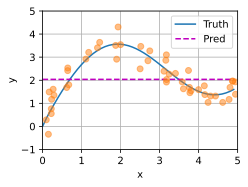

In [7]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

"""平均汇聚"""
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

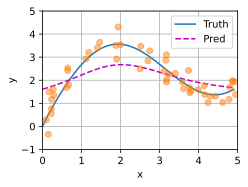

In [8]:
"""非参数注意力汇聚"""
# X_repeat的形状：（n_test,n_train）
# 每一行都包含相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# X_train包含着键，attention_weights的形状：（n_test,n_train）
# 每一行都包含这要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

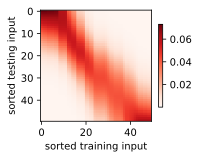

In [9]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='sorted training input',
                  ylabel='sorted testing input')

In [10]:
"""带参数的注意力汇聚"""
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [11]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [32]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs) :
        super(NWKernelRegression, self).__init__(**kwargs)
        self.w  = nn.Parameter(torch.rand(1, ), requires_grad=True)

    def forward(self, queries, keys, values):
        # queries， values和attention_weights的形状为（查询个数， 键值对个数）
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        print(queries.shape)
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2, dim=1)
        print(self.attention_weights.shape)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [30]:
"""训练"""
# X_tile的形状：（n_train,n_train），每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tain的形状：（n_train,n_train），每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys和values的形状为：（n_train,n_train-1）
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
x_train, X_tile.shape, keys, keys.shape

(tensor([0.0950, 0.1493, 0.1691, 0.2230, 0.2239, 0.2324, 0.2717, 0.2925, 0.6191,
         0.6439, 0.6456, 0.6712, 1.1095, 1.1826, 1.4080, 1.4638, 1.8738, 1.8992,
         1.9360, 1.9989, 2.5007, 2.5175, 2.7008, 2.7485, 3.1126, 3.1592, 3.1737,
         3.1753, 3.1772, 3.2444, 3.4061, 3.5798, 3.6108, 3.7400, 3.7639, 3.7759,
         3.8059, 3.9979, 4.1464, 4.1601, 4.2423, 4.3070, 4.4326, 4.6176, 4.7805,
         4.8047, 4.8709, 4.8714, 4.9389, 4.9446]),
 torch.Size([50, 50]),
 tensor([[0.1493, 0.1691, 0.2230,  ..., 4.8714, 4.9389, 4.9446],
         [0.0950, 0.1691, 0.2230,  ..., 4.8714, 4.9389, 4.9446],
         [0.0950, 0.1493, 0.2230,  ..., 4.8714, 4.9389, 4.9446],
         ...,
         [0.0950, 0.1493, 0.1691,  ..., 4.8709, 4.9389, 4.9446],
         [0.0950, 0.1493, 0.1691,  ..., 4.8709, 4.8714, 4.9446],
         [0.0950, 0.1493, 0.1691,  ..., 4.8709, 4.8714, 4.9389]]),
 torch.Size([50, 49]))

In [35]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)

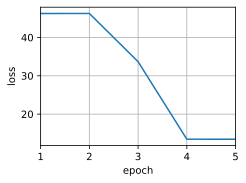

In [18]:
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss{float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

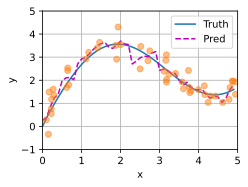

In [20]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

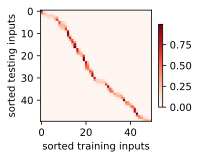

In [21]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='sorted training inputs',
                  ylabel='sorted testing inputs')

In [29]:
p = 1 - torch.eye(n_train)
q = p.type(torch.bool)
p, q

(tensor([[0., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 1.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 1., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 0.]]),
 tensor([[False,  True,  True,  ...,  True,  True,  True],
         [ True, False,  True,  ...,  True,  True,  True],
         [ True,  True, False,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ..., False,  True,  True],
         [ True,  True,  True,  ...,  True, False,  True],
         [ True,  True,  True,  ...,  True,  True, False]]))

In [36]:
net(x_train, keys, values).shape

torch.Size([50, 49])
torch.Size([50, 49])


torch.Size([50])

In [38]:
net.w, net.attention_weights

(Parameter containing:
 tensor([0.7765], requires_grad=True),
 tensor([[6.3218e-02, 6.3170e-02, 6.2963e-02,  ..., 6.5227e-05, 5.3643e-05,
          5.2744e-05],
         [6.1714e-02, 6.1761e-02, 6.1667e-02,  ..., 7.4381e-05, 6.1307e-05,
          6.0291e-05],
         [6.1144e-02, 6.1238e-02, 6.1191e-02,  ..., 7.8021e-05, 6.4359e-05,
          6.3297e-05],
         ...,
         [5.2744e-05, 6.1613e-05, 6.5181e-05,  ..., 5.1166e-02, 5.1096e-02,
          5.1083e-02],
         [4.4944e-05, 5.2618e-05, 5.5709e-05,  ..., 5.2940e-02, 5.2941e-02,
          5.3013e-02],
         [4.4330e-05, 5.1908e-05, 5.4962e-05,  ..., 5.3093e-02, 5.3095e-02,
          5.3180e-02]], grad_fn=<SoftmaxBackward0>))